# Tutorial: Ensemble Methods

Tutorial to the class [Ensemble Methods](8_ensemble_models).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
-
</div>

In [443]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis modules
import pandas as pd
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

def get_central_angle(lat1, lon1, lat2, lon2):
    '''To compute the distance between two points on a sphere.'''
    return np.arccos(np.sin(np.deg2rad(lat1)) * np.sin(np.deg2rad(lat2)) +
                     np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) *
                     np.cos(np.abs(np.deg2rad(lon2 - lon1))))

WIND_SPEED_LABEL = 'Wind Speed (m/s)'

In [444]:
# SIRTA data filepath
data_dir_sirta = Path('../../../data/raw/')
filename_sirta = 'reobs.nc'
filepath_sirta = Path(data_dir_sirta, filename_sirta)

# Load SIRTA data
ds_sirta = xr.load_dataset(filepath_sirta)
da_ws_sirta = ds_sirta['ws_sirta']
lat_sirta = float(ds_sirta.attrs['latitude'][:-1])
lon_sirta = float(ds_sirta.attrs['longitude'][:-1])

In [455]:
# Directories where you saved the data
data_dir_climate = Path('../../../data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'


def get_climate_model_variable(variable_name):
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir_climate, filename)
    da_climate = xr.load_dataset(filepath)
    
    return da_climate

# Read a climate variable
ds_clim = get_climate_model_variable('zonal_wind')
ds_clim = ds_clim.merge(get_climate_model_variable('meridional_wind'))
ds_clim['wind_speed'] = np.sqrt(ds_clim['zonal_wind']**2 +
                                ds_clim['meridional_wind']**2)
ds_clim['wind_direction'] = np.arctan2(ds_clim['meridional_wind'],
                                       ds_clim['zonal_wind'])
# Change direction to sine
ds_clim['sine_wind_direction'] = np.sin(ds_clim['wind_direction'])

In [446]:
from sklearn.model_selection import validation_curve

def evaluate_regressor(reg_class, reg_kwargs, param_coord,
                       plot_validation=True, plot_period=None):
    param_name = param_coord['param_name']
    param_range = param_coord['param_range']
    
    # Get test and train data
    X_test = X[-N_TEST:]
    y_test = y[-N_TEST:]
    X_train = X[:-N_TEST]
    y_train = y[:-N_TEST]

    # Define the estimator for particular regularization-parameter value
    # (set complexity to avoid potential errors even if will be overwritten)
    reg = reg_class(**{param_name: param_range[0]}, **reg_kwargs)

    # Get validation curve
    train_scores, validation_scores = validation_curve(
        reg, X_train, y_train, **param_coord, cv=N_SPLITS)
    train_scores_mean = train_scores.mean(1)
    train_scores_std = train_scores.std(1)
    validation_scores_mean = validation_scores.mean(1)
    validation_scores_std = validation_scores.std(1)

    # Get best value of the regularization parameter
    i_best = np.argmax(validation_scores_mean)
    param_best = param_range[i_best]
    score_best = validation_scores_mean[i_best]

    if plot_validation:
        # Plot validation curve
        lw = 2
        plt.figure()
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)
        plt.semilogx(param_range, validation_scores_mean,
                     label="Cross-validation score", color="navy", lw=lw)
        plt.fill_between(param_range,
                         validation_scores_mean - validation_scores_std,
                         validation_scores_mean + validation_scores_std,
                         alpha=0.2, color="navy", lw=lw)
        plt.xlabel(param_name)
        plt.ylabel(r'$r^2$')
        plt.title(region_name + r'. Best $r^2$: {:.2} for {} = {:.1e}'.format(
            score_best, param_name, param_best))
        plt.ylim(0.0, 1.1)
        plt.legend(loc="best")

    # Compute prediction error conditioned on first 5 years of data
    reg.set_params(**{param_name: param_best})
    reg.fit(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    print('\nTest r2: {:.2f}'.format(test_score))

    # Predict for work days and off days
    y_pred = reg.predict(X)

    # Plot prediction on top of train data
    y_plot = y if plot_period is None else y[plot_period]
    y_pred_plot = y_pred if plot_period is None else y_pred[plot_period]
    plt.figure()
    plt.plot(y_plot)
    plt.plot(y_pred_plot)
#     plt.xlabel()
    plt.ylabel(WIND_SPEED_LABEL)
    
    return {param_name: param_best}, reg

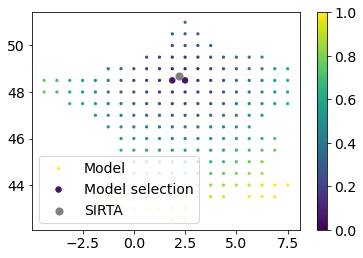

In [487]:
# Variable and grid-points to keep
VARIABLE_NAMES = ['wind_speed', 'sine_wind_direction']
N_GEO_NEIGHBORS = 2
POLY_DEGREE = 3
daily = False

# Get distance to SIRTA location in terms of great circle central angle
ds_clim['central_angle_sirta'] = get_central_angle(
    ds_clim['lat'], ds_clim['lon'], lat_sirta, lon_sirta)

# Keep nearest points
isort = np.argsort(ds_clim['central_angle_sirta']).values
ds_clim_near = ds_clim.isel(stacked_dim=isort[:N_GEO_NEIGHBORS])

if daily:
    da_ws_sirta = da_ws_sirta.resample(time='D').mean()
    ds_clim_near = ds_clim_near.resample(time='D').mean()

# Remove NaNs
da_ws_sirta = da_ws_sirta.dropna('time')

# Select common index
idx = da_ws_sirta.indexes['time'].intersection(ds_clim_near.indexes['time'])
da_ws_sirta = da_ws_sirta.loc[idx]
ds_clim_near = ds_clim_near.sel(time=idx, method='nearest')

# Plot selected grid points
vmin, vmax = 0., 0.1
plt.figure()
plt.scatter(ds_clim['lon'], ds_clim['lat'], c=ds_clim['central_angle_sirta'],
            s=5, label='Model', vmin=vmin, vmax=vmax)
c = ds_clim_near['central_angle_sirta']
if daily:
    c = ds_clim_near['central_angle_sirta'].isel(time=0)
plt.scatter(ds_clim_near['lon'], ds_clim_near['lat'],
            c=c, s=30, label='Model selection', vmin=vmin, vmax=vmax)
plt.scatter([lon_sirta], [lat_sirta], c='0.5', s=50, label='SIRTA')
plt.colorbar()
plt.legend(loc='lower left')

In [488]:
from sklearn import preprocessing

# Set number of splits for cross-validation
N_SPLITS = 6

# Dictionary of best complexity parameters
param_bests = {}

# Keep last two years for test
N_TEST = len(da_ws_sirta.coords['time'].sel(time=slice('2016', '2018')))
n_days_plot = 90 if daily else 90 * 24
plot_period = slice(-n_days_plot, None)

y = da_ws_sirta.values
X = np.concatenate([ds_clim_near[vn].values for vn in VARIABLE_NAMES], 1)
if POLY_DEGREE > 1:
    poly = preprocessing.PolynomialFeatures(POLY_DEGREE)
    X =  poly.fit_transform(X)

/home/atantet/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.4574279785156, tolerance: 214.556640625
  model = cd_fast.enet_coordinate_descent(
/home/atantet/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.8994140625, tolerance: 219.55760192871094
  model = cd_fast.enet_coordinate_descent(
/home/atantet/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.8084716796875, tolerance: 212.5146942138672
  model = cd_fast.enet_coordinate_descent(
/home/atantet/.conda/envs/default/lib/python3.9/site-packa


Test r2: 0.52


/home/atantet/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.58685302734375, tolerance: 217.5582275390625
  model = cd_fast.enet_coordinate_descent(


array([ 0.0000000e+00,  4.1816287e-02,  2.6846775e-01, -2.0099001e-02,
       -3.9704464e-02,  9.8427264e-03,  5.3638765e-03, -0.0000000e+00,
        7.7413216e-02,  2.0195835e-03, -2.0427888e-02,  2.6821094e-02,
        1.3630454e-01, -5.4470503e-01, -5.1951535e-02, -1.6954932e-03,
       -0.0000000e+00, -1.1706462e-02,  2.4702381e-03,  6.1133940e-04,
       -4.0299208e-03,  3.1964018e-03, -1.3751371e-02, -0.0000000e+00,
       -0.0000000e+00,  3.3270736e-04, -3.8670865e-03,  3.0599888e-03,
        1.5049709e-02, -0.0000000e+00,  3.7764829e-02,  1.5015605e-02,
       -4.7629754e-05,  3.9597131e-02,  0.0000000e+00], dtype=float32)

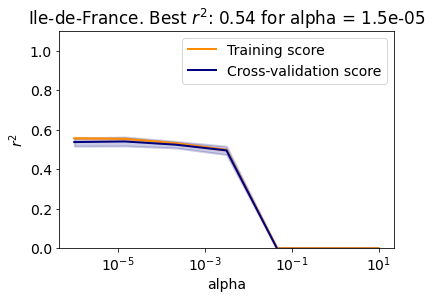

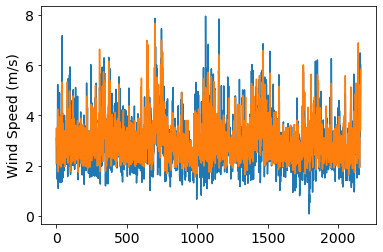

In [489]:
from sklearn import linear_model

# Define array of complexity coordinate, regressor and options
# for Lasso regression
param_coord_lasso = {'param_name': 'alpha',
                     'param_range': np.logspace(-6, 1, 7)}
reg_class_lasso = linear_model.Lasso
reg_kwargs_lasso = dict(fit_intercept=True, normalize=True,
                        warm_start=True, tol=1.e-1)

# Evaluate regressor
param_bests[reg_class_lasso.__name__], reg = evaluate_regressor(
    reg_class_lasso, reg_kwargs_lasso, param_coord_lasso,
    plot_period=plot_period)
reg.coef_


Test r2: 0.50


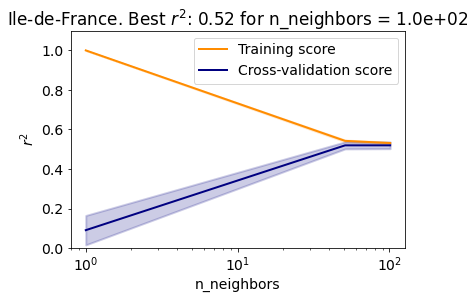

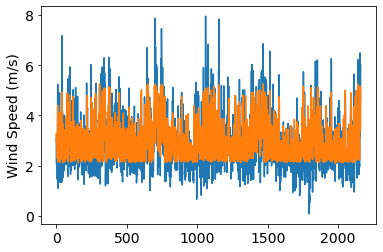

In [490]:
from sklearn import neighbors

# Define array of complexity coordinate, regressor and options
# for nearest-neighbors regression
param_coord_nn = {'param_name': 'n_neighbors',
                  'param_range': np.arange(1, 102, 50)}
reg_class_nn = neighbors.KNeighborsRegressor
reg_kwargs_nn = dict(n_jobs=8)

# Evaluate regressor
param_bests[reg_class_nn.__name__], reg = evaluate_regressor(
    reg_class_nn, reg_kwargs_nn, param_coord_nn, plot_period=plot_period)


Test r2: 0.44


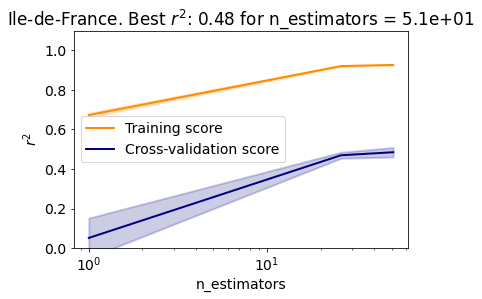

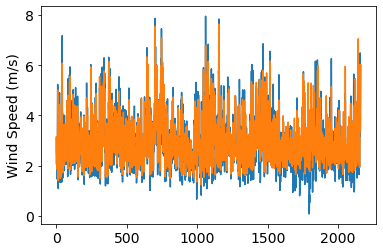

In [491]:
from sklearn import ensemble

# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_coord_rf = {'param_name': 'n_estimators',
                  'param_range': np.arange(1, 52, 25)}
reg_class_rf = ensemble.RandomForestRegressor
reg_kwargs_rf = dict(warm_start=True, n_jobs=8)

# Evaluate regressor
param_bests[reg_class_rf.__name__], reg = evaluate_regressor(
    reg_class_rf, reg_kwargs_rf, param_coord_rf, plot_period=plot_period)

Text(0, 0.5, 'Mean decrease in impurity')

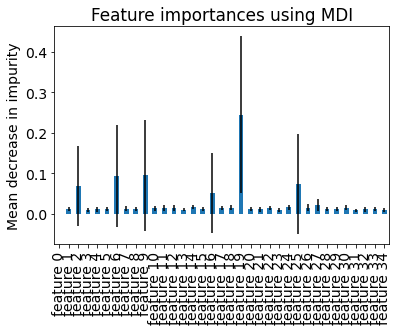

In [492]:
# Plot importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Test r2: 0.74


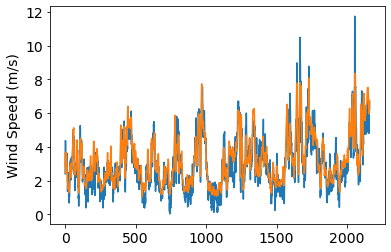

In [330]:
# Evaluate voting regressor
r1 = reg_class_lasso(
    **param_bests[reg_class_lasso.__name__], **reg_kwargs_lasso)
r2 = reg_class_nn(
    **param_bests[reg_class_nn.__name__], **reg_kwargs_nn)
r3 = reg_class_rf(
    **param_bests[reg_class_rf.__name__], **reg_kwargs_rf)

# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_coord_vr = {'param_name': 'estimators',
                  'param_range': [[('Lasso', r1),
                                   ('KNearestNeighbors', r2),
                                   ('RandomForest', r3)]]}
reg_class_vr = ensemble.VotingRegressor
reg_kwargs_vr = dict()

# Evaluate regressor
param_bests[reg_class_vr.__name__], reg = evaluate_regressor(
    reg_class_vr, reg_kwargs_vr, param_coord_vr, plot_validation=False,
    plot_period=plot_period)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>